# XGBoost

### Ensemble Learning

Imagine you have a complex problem to solve. Instead of relying on one super-smart model, you can use several slightly less-smart models, each looking at the data in a slightly different way, and then combined their predictions. Ensemble is a group of individual learning models that are called base learners or weak learners, whose predictions are combined to make a final prediction. Ensembles can often lead to a much more accurate overall model and are less prone to overfitting the training the data.

### Boosting

Boosting is a specific type of ensemble learning where the base learners are trained sequentially. Each new learner ties to correct the mistakes made by the previous learners. 

### Gradient Boosting

Gradient boosting is a generalisation of boosting that leverages the concept of gradient descent to build the ensemble. It starts with a simple initial prediction (e.g. the mean of the target variable for regression, or a log-odds for classification). For each data point, we calculate the residuals. 

Suppose we have a dataset $\{(x_i, y_i)\}_{i=1}^n$ where $x\in\mathbb R^p$ and $y_i\in\mathbb R$. Suppose we have a previous model, namely $F_{prev}$, whose prediction for $x_i$ is $F_{prev}(x_i)$. The "weakness" of the previous model can be defined as residual, the difference between the predicted value $F_{prev}(x_i)$ and the value $y_i$. Gradient Boosting improves the model by finding a function $h$ that reduces this residual. Suppose we have

$$
\begin{gather*}
y_1 = F_{prev}(x_1) + h(x_1)
\\
\vdots
\\
y_n = F_{prev}(x_n) + h(x_n).
\end{gather*}
$$

Then we aim to find a new function $F_{new}(x)$ as $F_{new}(x)=F_{prev}(x)+\alpha h(x)$, where we use the learning rate $\alpha$ to prevent overfitting. Let $M$ be the number of models that we are going to fit sequentially and $F_0(x)=h_0(x)$ be the prediction of the initial model. Then we have

$$
\begin{align*}
F_1(x) 
&= F_0(x) + \alpha h_1(x)
\\
&= h_0(x) + \alpha h_1(x)
\\
F_2(x) 
&= F_1(x) + \alpha h_2(x)
\\
&= h_0(x) + \alpha h_1(x) + \alpha h_2(x)
\\
\vdots
\\
F_M(x) &= h_0(x) + \alpha h_1(x) + \cdots + \alpha h_M(x)
\end{align*}
$$

where we can seee that the final model $F_M$ is the linear combination of $h_j$ for $j=0,\cdots, M$.

The algorithm can be summarised as the following:

1. Define the loss function $L(y, F(x))$ and set the learning rate $\alpha$.
2. Initialise the model $F_0(x)$ as a constant:
    $$
    F_0(x) = \arg\min_\gamma \sum_{i=1}^n L(y_i, \gamma).
    $$
3. For $m=1, \cdots, M$ iterate the following process:
    1. Find the pseudo-residual $r_{im}$ for $i=1,\cdots, m$:
        $$
        r_{im} = -\left[ \frac{\partial L(y_i, F(x_i))}{\partial F(x_i)} \right]_{F(x) = F_{m-1}(x)}
        $$
    2. Fit a base learner $g_m$ that predicts $r_{im}$. That is, fit a model using the dataset $\{(x_i, r_{im})\}_{i=1}^n$
    3. Calculate a constant $\gamma_m$:
        $$
        \gamma_m = \arg\min_\gamma \sum_{i=1}^n L(y_i, F_{m-1}(x_i) + \gamma g_m(x_i))
        $$
    4. Update hte model
        $$
        F_m(x) = F_{m-1}(x) + \alpha \gamma_m g_m(x)
        $$
4. Obtain the final model $F_M(x)$.

It is important to note that here we used $g_m(x_i)$ instead of $r_{im}$ when updating the model. This is because an individual $r_{im}$ is calculated from a certain data point $(x_i, y_i)$ and we cannot naively generalise this result. Therefore, we learn another model $g_m$ that can generalise and calculate pseudo-residual for an arbitrary $x$. 

### Gradient Tree Boosting

In the above Gradient Boosting algorithm, there is no constraint for $g_m$. Gradient Tree Boosting uses decision-tree as $g_m$. Let $J_m$ be the number of leaf nodes and $R_{jm}$ be the region for a $j$-th node for $j=1,\cdots, J_m$. A decision tree $g_m$ that fitted the dataset $\{(x_i, r_{im})\}_{i=1}^n$ is defined as 

$$
g_m(x) = \sum_{j=1}^{J_m} b_{jm}1_{x\in R_{jm}}
$$

where $1_{x\in R_{jm}}$ is an indicator funciton. After fitting $g_m$ we calculate the constant $\gamma_m$ as

$$
\gamma_m = \arg\min_\gamma \sum_{i=1}^n L(y_i, F_{m-1}(x_i) + \gamma g_m(x_i))
$$

and update the model as

$$
F_m(x) = F_{m-1}(x) + \alpha \gamma_m g_m(x)
$$

### XG Boost

XGBoost is a modified version of Gradient Tree Boosting algorithm. Here we consider two parmaeters $\gamma$ and $\lambda$ that enables regularisation. As in the previous section, we initialise the model $F_0(x)$ as a constant:

$$
F_0(x) = \arg\min_c \sum_{i=1}^n L(y_i, c).
$$

Then for $m=1,\cdots, M$ we iterate the following process:

1. Calculate the gradient $g_i$ and the Hessian $h_i$ for $i=1,\cdots, n$:
    $$
    \begin{gather*}
    g_i = \left[ \frac{\partial L(y_i, F(x_i))}{\partial F(x_i)} \right]_{F(x) = F_{m-1}(x)}
    \\
    h_i = \left[ \frac{\partial^2 L(y_i, F(x_i))}{\partial F(x_i)^2} \right]_{F(x) = F_{m-1}(x)}
    \end{gather*}
    $$
2. Fit a regression tree $\phi_m$:
    $$
    \phi_m = \arg\min_\phi \sum_{i=1}^n \frac{1}{2} h_i \left( -\frac{g_i}{h_i} - \phi(x_i) \right)^2 + \gamma T + \frac{1}{2}\lambda \|\phi\|^2
    $$
    where $T$ is the number of leaf nodes of $\phi$, $\|\phi\|^2=\sum_{j=1}^T w_j^2$ and $w_j$ is the weight of the $j$-th leaf node.
3. Update the model:
    $$
    F_m(x) = F_{m-1}(x) + \alpha \phi_m(x)
    $$
4. Obtain the final model $F_M(x) = \sum_{m=0}^M F_m(x)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import train_test_split

import xgboost as xgb
from xgboost import XGBRegressor, plot_importance, plot_tree

In [2]:
data = fetch_california_housing()
X = data.data
y = data.target
cols = data.feature_names

# Create a DataFrame from the features
X_df = pd.DataFrame(X, columns = cols)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"cols: {cols}")

X shape: (20640, 8)
y shape: (20640,)
cols: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


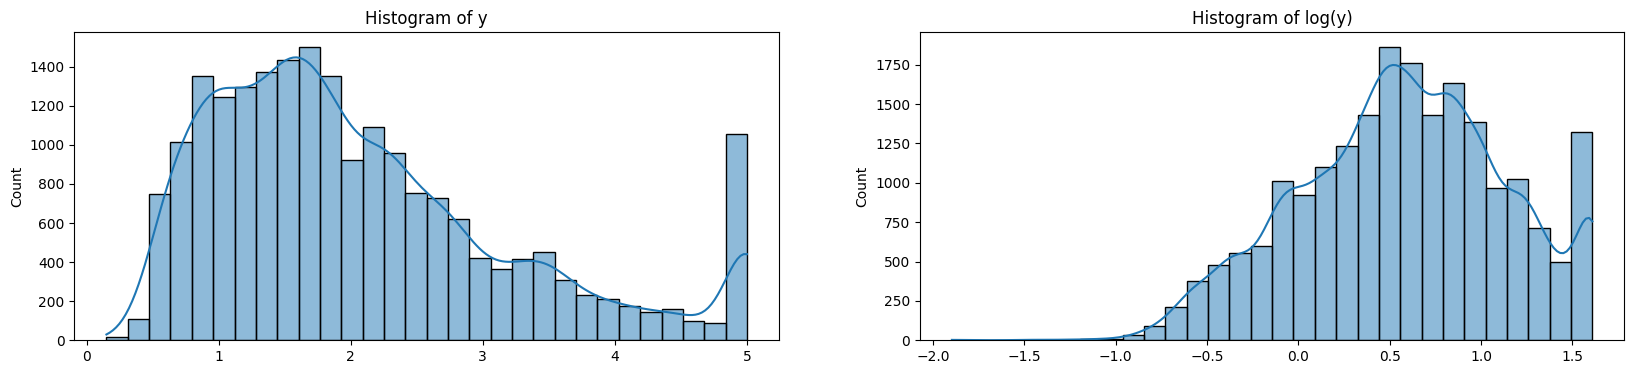

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(20, 4))

sns.histplot(y, ax=ax[0], bins=30, kde=True)
sns.histplot(np.log(y), ax=ax[1], bins=30, kde=True)

ax[0].set_title("Histogram of y")
ax[1].set_title("Histogram of log(y)")

plt.show()

In [4]:
# Apply log transformation to the target variable as the distribution is skewed to the right
y = np.log(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=42)

In [7]:
model = XGBRegressor(n_estimators=200)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_true = y_test

# Calculate the RMSE
mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse:.4f}")

MSE: 0.0512


<Figure size 1200x400 with 0 Axes>

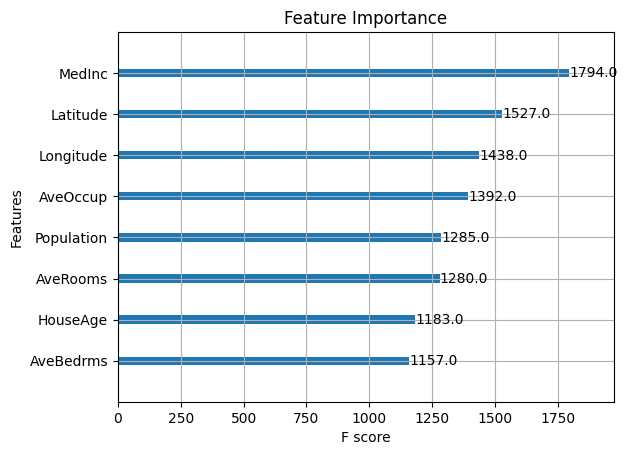

In [8]:
fig = plt.figure(figsize = (12, 4))

xgb.plot_importance(model)
plt.title("Feature Importance")
plt.show()

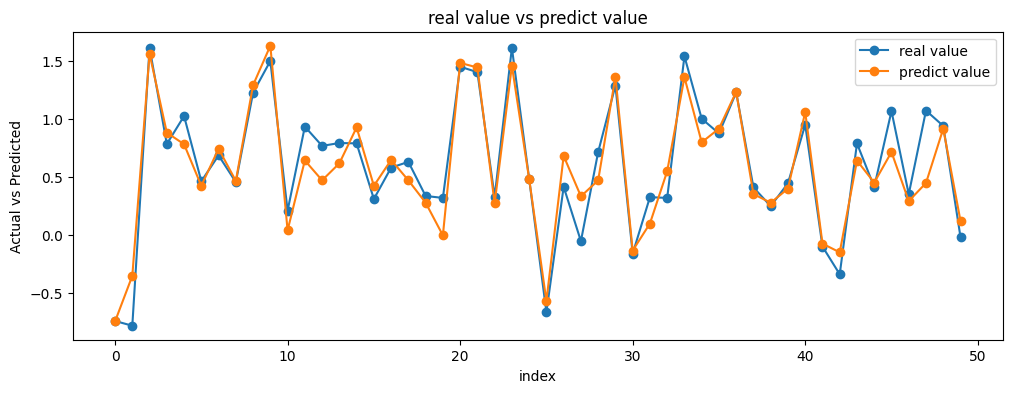

In [9]:
fig = plt.figure(figsize = (12, 4))

plt.plot(y_true[:50], marker='o', label='real value')
plt.plot(y_pred[:50], marker='o', label='predict value')
plt.title('real value vs predict value')
plt.xlabel('index')
plt.ylabel('Actual vs Predicted')
plt.legend(loc = 'best') 

plt.show()